# Set paths and get a list of all test images

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

#set path to model folder
model_path = 'C:\\Users\\SWONG\\PRS_project\\Model\\'

#input name of model to be tested
model_name = 'DenseNet121_AsymImg_final.hdf5'

#set path to test images
test_image_path_pos = 'C:\\Users\\SWONG\\PRS_project\\Asym_data\\test\\melanoma\\'
test_image_path_neg = 'C:\\Users\\SWONG\\PRS_project\\Asym_data\\test\\non_melanoma\\'

#load model to be tested
model = load_model(os.path.join(model_path,model_name))

#getting the lists of melanoma and non_melanoma images
image_list_pos = os.listdir(test_image_path_pos)
image_list_neg = os.listdir(test_image_path_neg)

image_list_all = []
for image in image_list_pos:
    image_list_all.append(os.path.join(test_image_path_pos,image))
for image in image_list_neg:
    image_list_all.append(os.path.join(test_image_path_neg,image))

# Function to preprocess test images to feed into model

In [2]:
import numpy as np
from tensorflow.keras.preprocessing import image

#preprocessing images to a nparray
def image_preprocessing_all(img_list):
    images = []
    for img in img_list:
        img = image.load_img(img,target_size=(224,224))
        images.append(np.asarray(img))
    images_np = np.array(images)
    return images_np

#storing all the test images in nparray format
images_np = image_preprocessing_all(image_list_all) 
print(images_np.shape)

(1002, 224, 224, 3)


# Predict test image classes and store results 

In [3]:
#storing the true label for the images in labelled_class
labelled_class = []
for img in image_list_pos:
    labelled_class.append(0)
for img in image_list_neg:
    labelled_class.append(1)
    
#class probabilites for each image in test set
pred_probs = model.predict(images_np)

print('Length of labelled_class list:', len(labelled_class))
print('Shape of pred_probs:', pred_probs.shape)

Length of labelled_class list: 1002
Shape of pred_probs: (1002, 1)


# Saving the predictions as an np array to train final classifier

In [4]:
# save numpy array as npy file
from numpy import asarray
from numpy import save

arr_path = model_path + '\\numpy_baseClassifier_predictions\\test_preds_asym.npy'

# save to npy file
save(arr_path, pred_probs)

# Model evaluation using accuracy and loss

In [5]:
score = model.evaluate(images_np, np.array(labelled_class), verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.34610453248023987
Test accuracy: 0.8822355270385742


# Accuracy, Classification Report, Confusion Matrix

In [6]:
from pycm import ConfusionMatrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#set the threshold of prediction probability that is considered non-melanoma
threshold = 0.5

#converting the prediction probabilities to a list of binary predictions
pred_class = []
for pred in pred_probs:
    if pred < threshold:
        pred_class.append(0)
    else:
        pred_class.append(1)
        
print("Accuracy:",accuracy_score(labelled_class,pred_class)*100)

Accuracy: 88.22355289421158


In [7]:
print("Report:", classification_report(labelled_class,pred_class))

Report:               precision    recall  f1-score   support

           0       0.46      0.36      0.40       111
           1       0.92      0.95      0.93       891

    accuracy                           0.88      1002
   macro avg       0.69      0.65      0.67      1002
weighted avg       0.87      0.88      0.88      1002



In [8]:
print(ConfusionMatrix(actual_vector=list(labelled_class),predict_vector=(pred_class)))

Predict   0         1         
Actual
0         40        71        

1         47        844       





Overall Statistics : 

95% CI                                                            (0.86228,0.90219)
ACC Macro                                                         0.88224
ARI                                                               0.29092
AUNP                                                              0.65381
AUNU                                                              0.65381
Bangdiwala B                                                      0.86546
Bennett S                                                         0.76447
CBA                                                               0.64138
CSI                                                               0.34489
Chi-Squared                                                       117.79606
Chi-Squared DF                                                    1
Conditional Entropy                                

# AUC Score (for models with 1 output layer!)

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#BINARY CLASS METHOD (which requires 1D output from model)
    
#getting AUC score
roc_auc = roc_auc_score(labelled_class, pred_probs)
print("AUC Score: ", roc_auc)

AUC Score:  0.7906391239724573


# Plot ROC curve and save (for models with 1 output layer!)

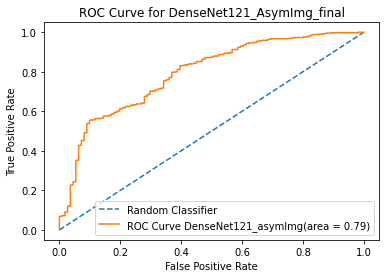

Path to plot: C:\Users\SWONG\PRS_project\Model\DenseNet121_AsymImg_final_roc.png


In [10]:
#plotting ROC
fpr, tpr, thresholds = roc_curve(labelled_class, pred_probs)
plt.figure()
plt.plot([0,1],[0,1],'--', label='Random Classifier')
plt.plot(fpr,tpr,label='ROC Curve DenseNet121_asymImg(area = %0.2f)' %roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for " + model_name.split('.')[0])
plt.legend(loc="lower right")

roc_plotpath  = model_path + model_name.split('.')[0] + '_roc.png'
plt.savefig(roc_plotpath)
plt.show()
print("Path to plot:", roc_plotpath)